In [128]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
from statsmodels.datasets import get_rdataset
import sklearn.model_selection as skm
from ISLP import load_data, confusion_table
from ISLP.models import ModelSpec as MS
from sklearn.tree import (DecisionTreeClassifier as DTC,
DecisionTreeRegressor as DTR,
plot_tree,
export_text)
from sklearn.metrics import (accuracy_score,
log_loss)
from sklearn.ensemble import \
(RandomForestRegressor as RF,
GradientBoostingRegressor as GBR)
from ISLP.bart import BART
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
import sklearn.linear_model as skl
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import make_scorer, accuracy_score

### Question 3: Gini, Entropy, and Classification Error Graphs

In [2]:
def gini(p1):
    """In a setting with two classes, p2 = 1 - p2"""
    p2 = 1 - p1
    G = p1*(1-p1) + p2*(1-p2)
    return G
    
def entropy(p1):
    p2 = 1 - p1
    epsilon = 1e-10 # add small epsilon to prevent log(0)
    D = -(p1*np.log(p1 + epsilon) + p2*np.log(p2 + epsilon))
    return D

def classification_error(p1):
    p2 = 1 - p1
    E = 1 - max(p1, p2)
    return E

In [3]:
p1_values = np.linspace(0, 1, 100)
ginis = [gini(p1) for p1 in p1_values]
entropies = [entropy(p1) for p1 in p1_values]
classification_errors = [classification_error(p1) for p1 in p1_values]

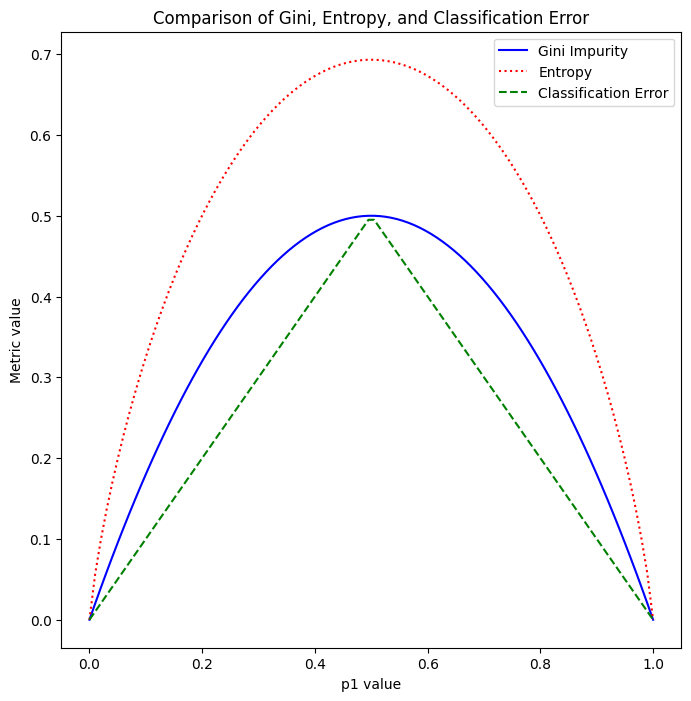

In [4]:
plt.figure(figsize=(8, 8))
plt.plot(p1_values, ginis, label='Gini Impurity', color='blue')
plt.plot(p1_values, entropies, label='Entropy', color='red', linestyle='dotted')
plt.plot(p1_values, classification_errors, label='Classification Error', color='green', linestyle='dashed')

# Adding labels and title
plt.xlabel('p1 value')
plt.ylabel('Metric value')
plt.title('Comparison of Gini, Entropy, and Classification Error')
plt.legend()

# Show plot
plt.show()

# Question 7 Test Error Plot

In [5]:
Boston = load_data("Boston")
model = MS(Boston.columns.drop('medv'), intercept=False)
D = model.fit_transform(Boston)
feature_names = list(D.columns)
X = np.asarray(D)

In [6]:
(X_train,
 X_test,
 y_train,
 y_test) = skm.train_test_split(X,
                                Boston['medv'],
                                test_size=0.3,
                                random_state=0)

In [7]:
max_features = [4, 5, 6, 7, 8]
n_estimators = np.arange(10, 700, 20) # number of trees

In [8]:
test_errors = np.zeros_like(n_estimators.reshape((-1, 1))*max_features, dtype=np.float32) # matrix of zeros, cols are max_features, rows are n_estimators
for i, n in enumerate(n_estimators):
    for j, m in enumerate(max_features):
        RF_boston = RF(max_features=m,
                       random_state=42,
                       n_estimators=n).fit(X_train, y_train)
        y_hat_RF = RF_boston.predict(X_test)
        test_errors[i, j] = np.mean((y_test - y_hat_RF)**2)

In [9]:
len(Boston.columns)

13

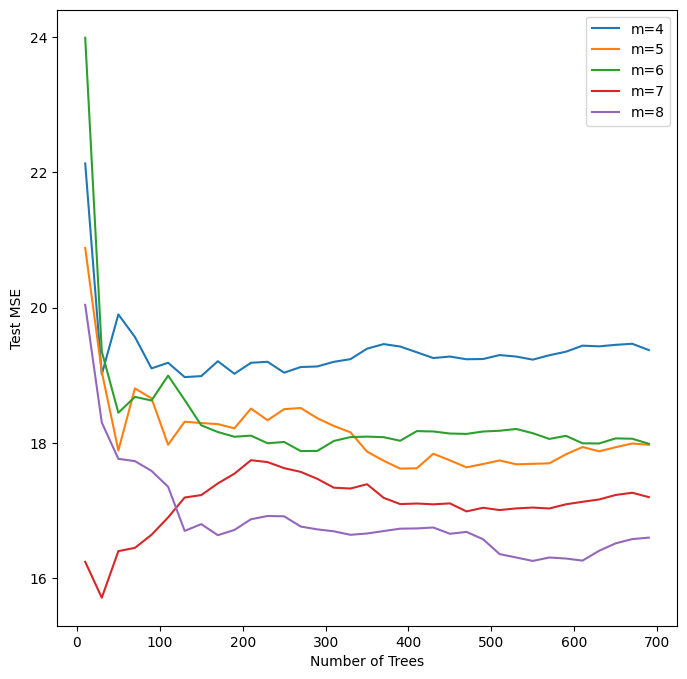

In [10]:
plt.figure(figsize=(8, 8))
for j, m in enumerate(max_features):
    plt.plot(n_estimators, test_errors[:, j], label=f'm={m}')

plt.legend()
plt.xlabel('Number of Trees')
plt.ylabel('Test MSE')
plt.show()

# Question 8 Carseats

### (a) Test/Train

In [11]:
Carseats = load_data('Carseats')
model = MS(Carseats.columns.drop('Sales'), intercept=False)
D = model.fit_transform(Carseats)
feature_names = list(D.columns)
X = np.asarray(D)

In [12]:
(X_train,
 X_test,
 y_train,
 y_test) = skm.train_test_split(X,
                                Carseats['Sales'],
                                test_size=0.25,
                                random_state=42)

### (b) Fit a regression tree

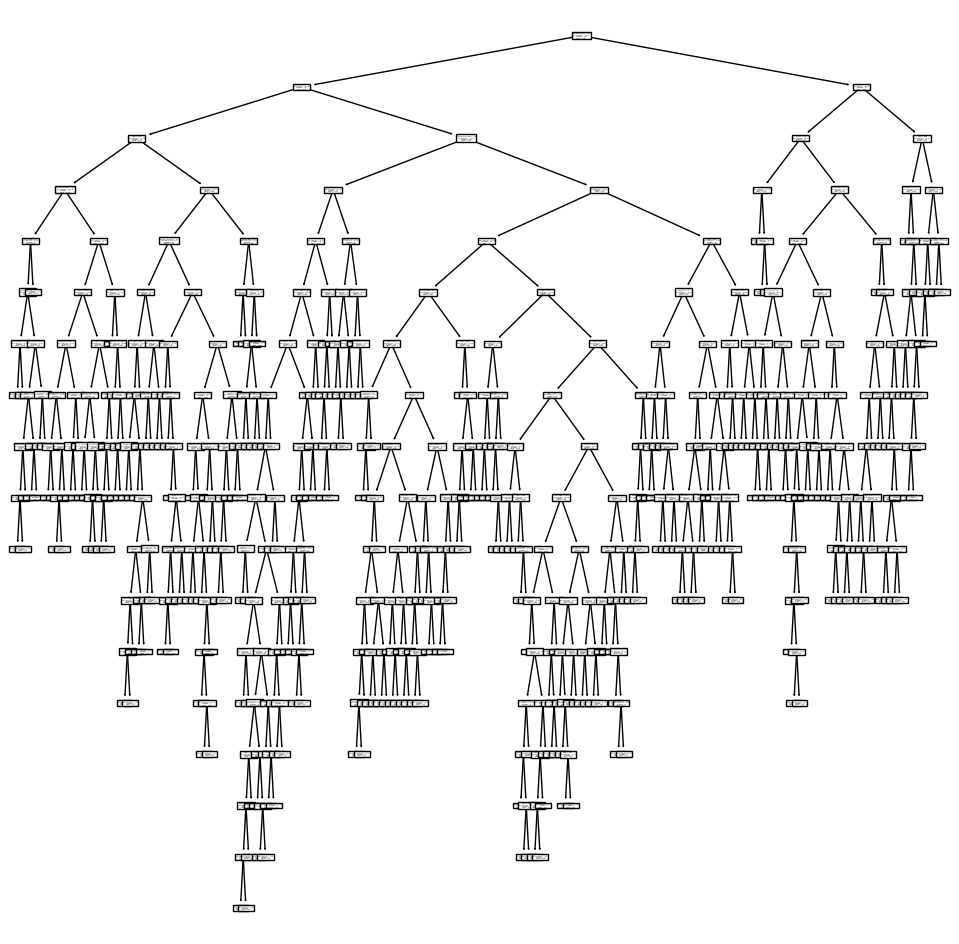

In [13]:
reg = DTR()
reg.fit(X_train, y_train)
ax = subplots(figsize=(12,12))[1]
plot_tree(reg,
          feature_names=feature_names,
          ax=ax);

In [14]:
yhat = reg.predict(X_test)
np.mean((y_test - yhat)**2)

5.071693

### (c) Use cross-validation to determine tree complexity

In [15]:
ccp_path = reg.cost_complexity_pruning_path(X_train, y_train)
kfold = skm.KFold(5,
                  shuffle=True,
                  random_state=10)
grid = skm.GridSearchCV(reg,
                        {'ccp_alpha': ccp_path.ccp_alphas},
                        refit=True,
                        cv=kfold,
                        scoring='neg_mean_squared_error')
grid.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=10, shuffle=True),
             estimator=DecisionTreeRegressor(),
             param_grid={'ccp_alpha': array([0.00000000e+00, 1.66666667e-07, 6.66666667e-07, 6.66666667e-07,
       1.50000000e-06, 1.50000000e-06, 1.50000000e-06, 1.50000000e-06,
       2.66666667e-06, 2.66666667e-06, 4.16666667e-06, 4.16666667e-06,
       6.00000000e-06, 6.00000000e-06, 6.00000000e-...
       4.60368779e-02, 4.68220801e-02, 5.95578981e-02, 6.12306250e-02,
       6.60248037e-02, 6.97879826e-02, 7.14025000e-02, 7.22916741e-02,
       7.34326751e-02, 7.44433653e-02, 9.41499273e-02, 9.65864854e-02,
       1.11344001e-01, 1.14305742e-01, 1.31564484e-01, 1.50400267e-01,
       1.82308879e-01, 2.46023875e-01, 2.48733972e-01, 3.40943112e-01,
       3.63215824e-01, 4.30873773e-01, 9.01855937e-01, 1.49122968e+00])},
             scoring='neg_mean_squared_error')

In [16]:
best_ = grid.best_estimator_
np.mean((y_test - best_.predict(X_test))**2)

4.801502096571304

In [17]:
best_.ccp_alpha

0.06123062500000003

### (d) Bagging

In [18]:
bag = RF(max_features=X_train.shape[1],
                n_estimators=500,
                random_state=0).fit(X_train, y_train)
y_hat_bag = bag.predict(X_test)
np.mean((y_test - y_hat_bag)**2)

2.8243561308200085

In [19]:
feature_imp = pd.DataFrame(
    {'importance':bag.feature_importances_},
    index=feature_names)
feature_imp.sort_values(by='importance', ascending=False)

,importance
Price,0.323730
ShelveLoc[Good],0.196061
Age,0.113312
CompPrice,0.101730
Advertising,0.078297
ShelveLoc[Medium],0.053176
Income,0.048901
Population,0.040869
Education,0.029355
US[Yes],0.007411


### (e) Random Forests

In [20]:
rf = RF(max_features='sqrt',
               random_state=0).fit(X_train, y_train)
y_hat_RF = rf.predict(X_test)
np.mean((y_test - y_hat_RF)**2)

3.436807354799998

In [21]:
feature_imp = pd.DataFrame(
    {'importance':rf.feature_importances_},
    index=feature_names)
feature_imp.sort_values(by='importance', ascending=False)

,importance
Price,0.265172
ShelveLoc[Good],0.147470
Age,0.119307
Advertising,0.105648
CompPrice,0.091938
Income,0.082528
Population,0.073800
Education,0.047985
ShelveLoc[Medium],0.040187
US[Yes],0.014981


Similar importance metrics.

### (f) BART

In [22]:
bart = BART(random_state=0, burnin=5, ndraw=15)
bart.fit(X_train, y_train)

BART(burnin=5, ndraw=15, random_state=0)

In [23]:
yhat_test = bart.predict(X_test.astype(np.float32))
np.mean((y_test - yhat_test)**2)

1.3840737336940874

In [24]:
var_inclusion = pd.Series(bart.variable_inclusion_.mean(0),
                               index=D.columns)
var_inclusion

CompPrice            29.733333
Income               26.400000
Advertising          23.866667
Population           23.133333
Price                34.866667
ShelveLoc[Good]      32.800000
ShelveLoc[Medium]    30.666667
Age                  25.400000
Education            23.333333
Urban[Yes]           25.666667
US[Yes]              27.333333
dtype: float64

BART gives a slightly different composition of feature importance.

# Question 9

In [25]:
OJ = load_data('OJ')

In [26]:
OJ.head()

,Purchase,WeekofPurchase,StoreID,PriceCH,PriceMM,DiscCH,DiscMM,SpecialCH,SpecialMM,LoyalCH,SalePriceMM,SalePriceCH,PriceDiff,Store7,PctDiscMM,PctDiscCH,ListPriceDiff,STORE
0,CH,237,1,1.75,1.99,0.00,0.0,0,0,0.500000,1.99,1.75,0.24,No,0.000000,0.000000,0.24,1
1,CH,239,1,1.75,1.99,0.00,0.3,0,1,0.600000,1.69,1.75,-0.06,No,0.150754,0.000000,0.24,1
2,CH,245,1,1.86,2.09,0.17,0.0,0,0,0.680000,2.09,1.69,0.40,No,0.000000,0.091398,0.23,1
3,MM,227,1,1.69,1.69,0.00,0.0,0,0,0.400000,1.69,1.69,0.00,No,0.000000,0.000000,0.00,1
4,CH,228,7,1.69,1.69,0.00,0.0,0,0,0.956535,1.69,1.69,0.00,Yes,0.000000,0.000000,0.00,0


### (a) Train/Test

In [27]:
model = MS(OJ.columns.drop(['Purchase', 'Store7']), intercept=False)
D = model.fit_transform(OJ)
feature_names = list(D.columns)
X = np.asarray(D)

(X_train,
 X_test,
 y_train,
 y_test) = skm.train_test_split(X,
                                OJ['Purchase'],
                                train_size=800,
                                random_state=42)

### (b) Tree

In [28]:
clf = DTC(criterion='entropy', random_state=0)
clf.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=0)

In [29]:
def classification_error(y_true, y_hat):
    return np.mean(y_true != y_hat)

In [30]:
yhat = clf.predict(X_train)
classification_error(y_train, yhat) # training error

0.0075

### (c) Tree Plot

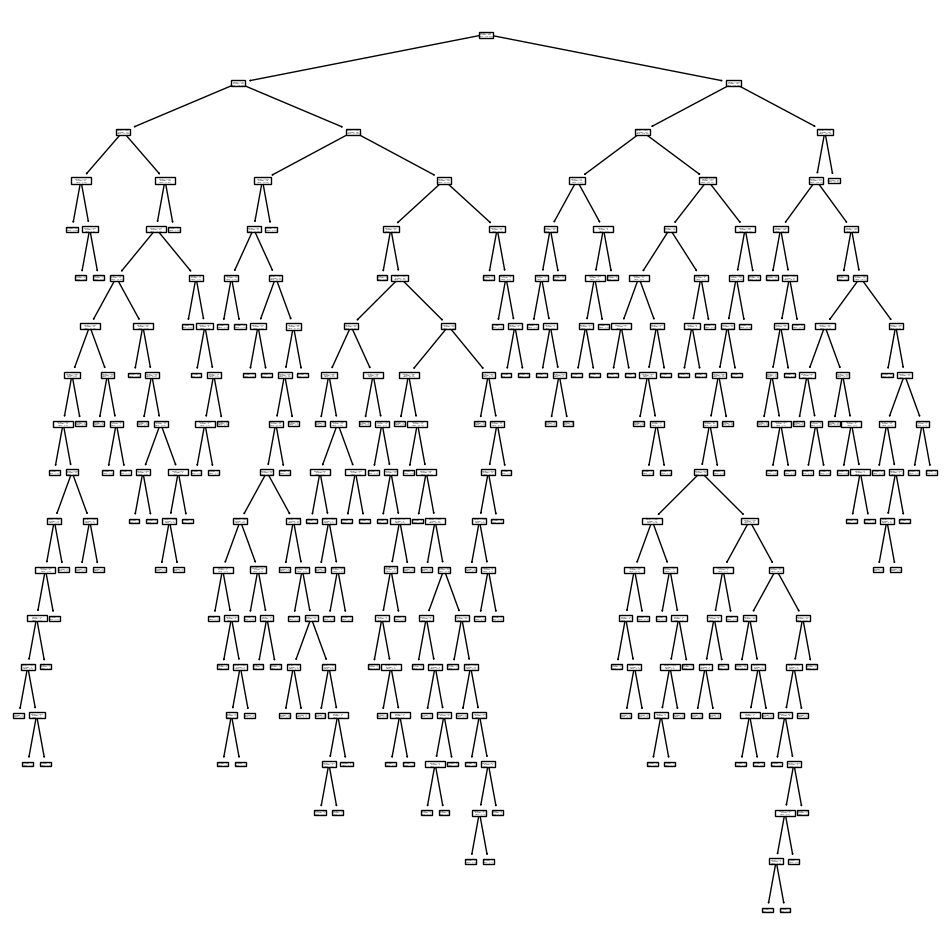

In [31]:
ax = subplots(figsize=(12,12))[1]
plot_tree(clf,
          feature_names=feature_names,
          ax=ax);

In [32]:
clf.tree_.n_leaves

164

### (d) export text

In [33]:
print(export_text(clf,
                  feature_names=feature_names,
                  show_weights=True))

|--- LoyalCH <= 0.50
|   |--- LoyalCH <= 0.28
|   |   |--- LoyalCH <= 0.06
|   |   |   |--- WeekofPurchase <= 268.50
|   |   |   |   |--- weights: [0.00, 58.00] class: MM
|   |   |   |--- WeekofPurchase >  268.50
|   |   |   |   |--- SalePriceMM <= 2.15
|   |   |   |   |   |--- weights: [0.00, 8.00] class: MM
|   |   |   |   |--- SalePriceMM >  2.15
|   |   |   |   |   |--- weights: [1.00, 0.00] class: CH
|   |   |--- LoyalCH >  0.06
|   |   |   |--- WeekofPurchase <= 273.50
|   |   |   |   |--- WeekofPurchase <= 261.50
|   |   |   |   |   |--- STORE <= 1.50
|   |   |   |   |   |   |--- WeekofPurchase <= 242.50
|   |   |   |   |   |   |   |--- SalePriceCH <= 1.77
|   |   |   |   |   |   |   |   |--- WeekofPurchase <= 228.50
|   |   |   |   |   |   |   |   |   |--- weights: [2.00, 0.00] class: CH
|   |   |   |   |   |   |   |   |--- WeekofPurchase >  228.50
|   |   |   |   |   |   |   |   |   |--- STORE <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- LoyalCH <= 0.22
|   |   |   |  

### (e) Test data, confusion matrix, test error

In [34]:
yhat = clf.predict(X_test)
print(classification_error(y_test, yhat))
confusion = confusion_table(yhat,
                            y_test)
confusion

0.23703703703703705


Truth,CH,MM
Predicted,,
CH,130,35
MM,29,76


### (f) Cross-validation

In [35]:
grid = skm.GridSearchCV(clf,
                        {'max_depth': np.arange(1, 20)},
                        refit=True,
                        cv=kfold,
                        scoring='accuracy')
grid.fit(X_train, y_train)
grid.best_score_

0.8162500000000001

In [36]:
best_ = grid.best_estimator_
best_.get_depth()

3

### (g) Tree size plot

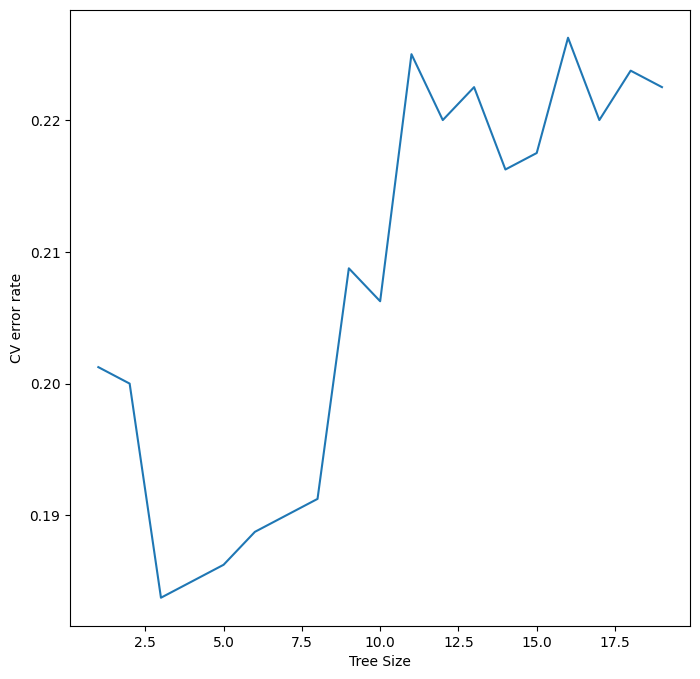

In [37]:
errors = 1 - grid.cv_results_['mean_test_score']
plt.figure(figsize=(8,8))
plt.plot(np.arange(1, 20), errors)
plt.ylabel('CV error rate')
plt.xlabel('Tree Size')
plt.show()

### (h) Best tree size is 3

### (i) Best tree

In [38]:
clf = best_.fit(X_train, y_train)

### (j) Tree Plot

In [39]:
yhat = clf.predict(X_train)
classification_error(y_train, yhat)

0.1525

Higher training error rate, this makes sense because we increase bias for a less variance, to minimize test error.

### (k) Test Error Comparison

In [40]:
yhat = clf.predict(X_test)
classification_error(y_test, yhat)

0.1962962962962963

This model has a lower test error, as expected.

# Question 10

### (a) Data Cleaning

In [41]:
Hitters = load_data('Hitters')
Hitters.dropna(inplace=True)
Hitters['Salary_log'] = Hitters['Salary'].apply(np.log)

### (b) Train/Test

In [42]:
model = MS(Hitters.columns.drop(['Salary', 'Salary_log']), intercept=False)
D = model.fit_transform(Hitters)
feature_names = list(D.columns)
X = np.asarray(D)

(X_train,
 X_test,
 y_train,
 y_test) = skm.train_test_split(X,
                                Hitters['Salary_log'],
                                train_size=200,
                                shuffle=False)

### (c) Boosting

In [43]:
training_MSE = []
test_MSE = []
learning_rates = [0.1, 0.05 ,0.01, 0.005, 0.001]
for learning_rate in learning_rates:
    bst = GBR(n_estimators=1000,
              learning_rate=learning_rate,
              random_state=0)
    bst.fit(X_train, y_train)
    # train MSE
    yhat = bst.predict(X_train)
    mse_train = np.mean((y_train - yhat)**2)
    training_MSE.append(mse_train)
    # test MSE
    yhat = bst.predict(X_test)
    mse_test = np.mean((y_test - yhat)**2)
    test_MSE.append(mse_test)

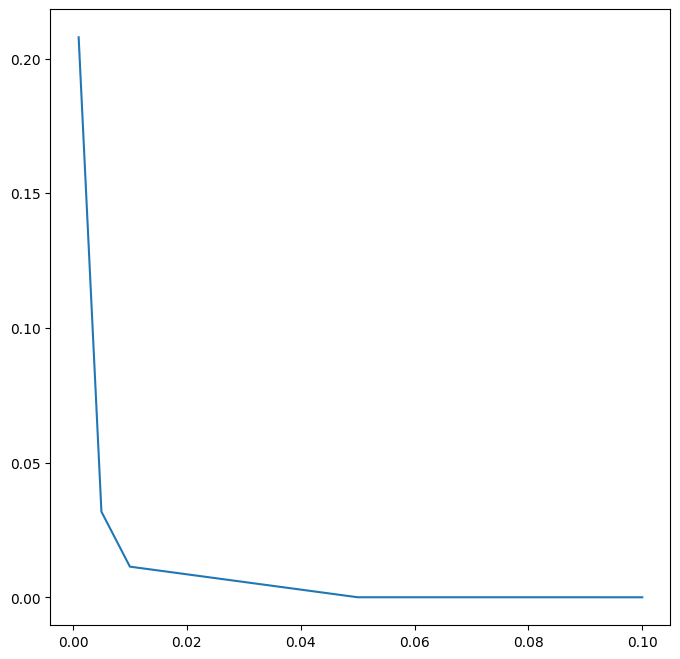

In [44]:
plt.figure(figsize=(8,8))
plt.plot(learning_rates, training_MSE)
plt.show()

### (d) Test set MSE

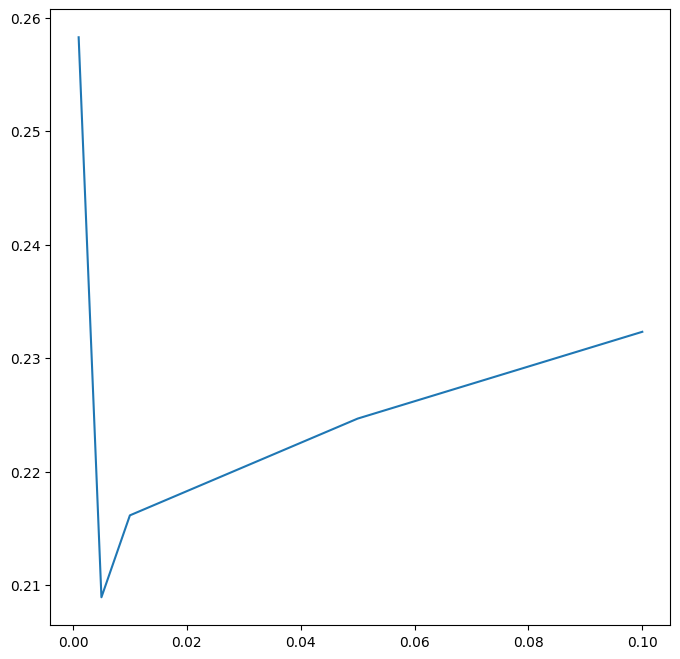

In [45]:
plt.figure(figsize=(8,8))
plt.plot(learning_rates, test_MSE)
plt.show()

### (e) Lasso & PCR Test MSEs

In [46]:
# Lasso
scaler = StandardScaler()
lassoCV = skl.ElasticNetCV(n_alphas=100, 
                           l1_ratio=1,
                           cv=kfold)
pipeCV = Pipeline(steps=[('scaler', scaler),
                         ('lasso', lassoCV)])
pipeCV.fit(X_train, y_train)
tuned_lasso = pipeCV.named_steps['lasso']

In [47]:
tuned_lasso.alpha_

0.002502970636367838

In [48]:
yhat = pipeCV.predict(X_test)
np.mean((y_test - yhat)**2)

0.4721983885499318

In [49]:
# PCR
pca = PCA(n_components=2)
linreg = skl.LinearRegression()
pipe = Pipeline([('scaler', scaler), 
                 ('pca', pca),
                 ('linreg', linreg)])

param_grid = {'pca__n_components': range(1, 20)}
grid = skm.GridSearchCV(pipe,
                        param_grid,
                        cv=kfold,
                        scoring='neg_mean_squared_error')
grid.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=10, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA(n_components=2)),
                                       ('linreg', LinearRegression())]),
             param_grid={'pca__n_components': range(1, 20)},
             scoring='neg_mean_squared_error')

In [50]:
grid.best_params_

{'pca__n_components': 17}

In [51]:
yhat = grid.predict(X_test)
np.mean((y_test - yhat)**2)

0.48657527483546475

Boosting outperforms both models.

### (f) Important Predictors

In [52]:
bst = GBR(n_estimators=1000,
              learning_rate=0.05,
              random_state=0)
bst.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.05, n_estimators=1000, random_state=0)

In [53]:
feature_names=D.columns
feature_imp = pd.DataFrame({'importance':bst.feature_importances_},index=feature_names)
feature_imp.sort_values(by='importance', ascending=False)

,importance
CAtBat,0.522894
CHits,0.102401
AtBat,0.054613
CRuns,0.054122
Walks,0.046087
CHmRun,0.036348
CRBI,0.035928
CWalks,0.028644
Years,0.027464
Hits,0.024992


### (g) Bagging

In [54]:
bag = RF(max_features=X_train.shape[1], random_state=0)
bag.fit(X_train, y_train)

RandomForestRegressor(max_features=19, random_state=0)

In [55]:
yhat = bag.predict(X_test)
np.mean((y_test - yhat)**2)

0.23742750495074605

# Question 11

### (a) Train/Test

In [63]:
Caravan = load_data('Caravan')
Caravan['Purchase'] = Caravan['Purchase'].apply(lambda x: 1 if x == 'Yes' else 0)

In [65]:
model = MS(Caravan.columns.drop(['Purchase']), intercept=False)
D = model.fit_transform(Caravan)
feature_names = list(D.columns)
X = np.asarray(D)

(X_train,
 X_test,
 y_train,
 y_test) = skm.train_test_split(X,
                                Caravan['Purchase'],
                                train_size=1000,
                                shuffle=False)

### (b) Boosting

In [67]:
bst = GBR(n_estimators=1000,
          learning_rate=0.01,
          random_state=0)
bst.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.01, n_estimators=1000, random_state=0)

In [68]:
feature_names=D.columns
feature_imp = pd.DataFrame({'importance':bst.feature_importances_},index=feature_names)
feature_imp.sort_values(by='importance', ascending=False)

,importance
PPERSAUT,0.075103
MOSTYPE,0.067000
MGODGE,0.059008
ABRAND,0.054300
MKOOPKLA,0.050978
...,...
AVRAAUT,0.000000
AWABEDR,0.000000
PVRAAUT,0.000000
PWERKT,0.000000


### (c) Predictions

In [78]:
ypred = bst.predict(X_test) > 0.2
confusion_table(y_test, ypred)

Truth,0,1
Predicted,,
0,4271,262
1,247,42


In [80]:
42/(247+42) # Precision

0.1453287197231834

Worse than both knn and logistic regression in this case.

# Question 12

In [57]:
Smarket = load_data('Smarket')

In [58]:
Smarket.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,2001,0.381,-0.192,-2.624,-1.055,5.010,1.1913,0.959,Up
1,2001,0.959,0.381,-0.192,-2.624,-1.055,1.2965,1.032,Up
2,2001,1.032,0.959,0.381,-0.192,-2.624,1.4112,-0.623,Down
3,2001,-0.623,1.032,0.959,0.381,-0.192,1.2760,0.614,Up
4,2001,0.614,-0.623,1.032,0.959,0.381,1.2057,0.213,Up


In [82]:
Smarket['Direction'] = Smarket['Direction'].apply(lambda x: 1 if x == 'Up' else 0)

### Train/Test

In [84]:
Smarket.shape

(1250, 9)

In [101]:
model = MS(Smarket.columns.drop(['Direction', 'Today', 'Year']), intercept=False)
D = model.fit_transform(Smarket)
feature_names = list(D.columns)
X = np.asarray(D)

(X_train,
 X_test,
 y_train,
 y_test) = skm.train_test_split(X,
                                Smarket['Direction'],
                                test_size=252, # only 2005
                                shuffle=False)

### Boosting

In [107]:
learning_rates = [0.01, 0.005, 0.001]
bst = GradientBoostingClassifier(n_estimators=1000,
                   learning_rate=0.001,
                   random_state=0)
grid = skm.GridSearchCV(bst,
                        {'learning_rate': learning_rates},
                        refit=True,
                        cv=kfold,
                        scoring='accuracy')
grid.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=10, shuffle=True),
             estimator=GradientBoostingClassifier(learning_rate=0.001,
                                                  n_estimators=1000,
                                                  random_state=0),
             param_grid={'learning_rate': [0.01, 0.005, 0.001]},
             scoring='accuracy')

In [109]:
grid.cv_results_['mean_test_score']

array([0.49901508, 0.48098995, 0.51105528])

### Bagging

In [110]:
bag = RF(max_features=X_train.shape[1], random_state=0)
bag.fit(X_train, y_train)

RandomForestRegressor(max_features=6, random_state=0)

In [113]:
yhat = bag.predict(X_test) > 0.5
classification_error(y_test, yhat)

0.49603174603174605

### Random Forests

In [119]:
rf = RF(max_features=2, random_state=0, n_estimators=1000) # m = p/2
rf.fit(X_train, y_train)

RandomForestRegressor(max_features=2, n_estimators=1000, random_state=0)

In [120]:
yhat = rf.predict(X_test) > 0.5
classification_error(y_test, yhat)

0.503968253968254

### BART

In [135]:
def threshold_accuracy(y_true, y_pred_proba, threshold=0.5):
    # Threshold probabilities to convert them to class labels
    y_pred = (y_pred_proba >= threshold).astype(int)
    return accuracy_score(y_true, y_pred)

custom_accuracy_scorer = make_scorer(threshold_accuracy)

In [136]:
bart = BART(random_state=0, ndraw=15, num_trees=100)
param_grid = {
    'burnin': [20, 50],
    'num_trees': [100, 300]
}

grid = skm.GridSearchCV(bart,
                    param_grid,
                    refit=True,
                    cv=kfold,
                    scoring=custom_accuracy_scorer)

grid.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=10, shuffle=True),
             estimator=BART(ndraw=15, num_trees=100, random_state=0),
             param_grid={'burnin': [20, 50], 'num_trees': [100, 300]},
             scoring=make_scorer(threshold_accuracy))

In [137]:
grid.cv_results_['mean_test_score']

array([0.51103518, 0.49898492, 0.50299497, 0.49999497])

In [138]:
best_ = grid.best_estimator_

In [139]:
yhat = best_.predict(X_test) > 0.5
classification_error(y_test, yhat)

0.4246031746031746

Did well on the test data, not too well on cv. Compared to logistic regression from one of the previous labs, based on test error, BART performed better.